# Top Shooter
The purpose of this analysis is to determine what type of player we can invest in based on our data set of Hockey teams from the year 2015 - 2019. The definitions for the variables that make up the model are;
#### TOI: 
Total amount of playing time
#### Shot Attempts:
Any shot attempt (goals, shots on net, misses and blocks) outside of the shootout. 
#### Shots:
Any shot attempt on net (goals and shots on net) outside of the shootout.

The hypothesis in this section is variables; 'Shots', 'TOI' and 'SH%' determine 'Puck Possession'. Is a player with high puck possession more likely to belong to a winning team? Are these variables consistent with these players over the years? Is there a correlation between these variables and goal scoring? We will find out more the further we look

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import scipy, scipy.stats
from scipy.stats import linregress
from pandas import DataFrame, Series
from pandas.plotting import autocorrelation_plot
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
%run ./data-loading.ipynb

import warnings
warnings.filterwarnings("ignore")

In [182]:
# Fetch the common set of player data everyone on the team is working with
player_data = fetch_player_data()
player_data.head()

Team Position  GP          TOI  Goals  Total Assists  \
Year Player                                                               
2015 Jamie Benn     DAL        F  82  1635.733333     35             52   
     John Tavares   NYI        F  82  1695.200000     38             48   
     Sidney Crosby  PIT        F  77  1538.533333     28             56   
     Alex Ovechkin  WSH        F  81  1646.400000     53             28   
     Jakub Voracek  PHI        F  82  1524.633333     22             59   

                    First Assists  Second Assists  Total Points  Shots    SH%  \
Year Player                                                                     
2015 Jamie Benn                32              20            87    253  13.83   
     John Tavares              30              18            86    278  13.67   
     Sidney Crosby             31              25            84    237  11.81   
     Alex Ovechkin             21               7            81    395  13.42   
     Jakub Voracek             31              28            81    221   9.95   

                    Shot Attempts  Hits  Hits Taken  
Year Player                                          
2015 Jamie Benn               466   120         101  
     John Tavares             471    48         103  
     Sidney Crosby            380    66         117  
     Alex Ovechkin            825   259         108  
     Jakub Voracek            424    55         139

In [183]:
#We want to begin the analysis by looking at the parameters for the data
player_data.describe()

,GP,TOI,Goals,Total Assists,First Assists,Second Assists,Total Points,Shots,SH%,Shot Attempts,Hits,Hits Taken
count,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000,3482.000000
mean,61.298966,1024.563694,9.786904,16.473578,9.127800,7.345778,26.260482,106.335439,8.284144,197.033027,77.394026,77.730327
std,19.549904,466.009903,9.002631,13.030163,7.895943,5.989066,20.382402,64.912201,4.741581,117.961018,53.616231,37.882451
min,20.000000,156.816667,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,13.000000,1.000000,5.000000
25%,47.000000,629.183333,3.000000,6.000000,3.000000,3.000000,10.000000,54.000000,4.690000,103.000000,38.000000,49.000000
50%,67.000000,1048.091667,7.000000,13.000000,7.000000,6.000000,20.000000,94.000000,8.000000,178.000000,65.000000,74.000000
75%,79.000000,1380.762500,14.000000,23.000000,13.000000,11.000000,38.000000,147.000000,11.460000,272.000000,104.000000,101.000000
max,82.000000,2377.666667,53.000000,87.000000,57.000000,35.000000,128.000000,398.000000,33.330000,825.000000,382.000000,293.000000


A basic linear model lets us know these important data points for the data set.

### Disecting the Variables 'Shots', 'Shot Attempts' & 'TOI'

We will begin dissecting the data and the results should give us more insight into these variables relate to winning. The results should also let inform us if these variables are consistent over time.

In [184]:
# Grouped the players by Teams to see what Teams outperform the others in the league
sorted_teams = player_data.groupby('Team')[['Shots', 'Shot Attempts', 'TOI']].aggregate(['min','max', 'sum'])
sorted_teams.head(10)

Shots             Shot Attempts                     TOI               \
       min  max    sum           min  max    sum         min          max   
Team                                                                        
ANA      7  230  11630            25  406  22127  201.466667  1987.850000   
ARI     21  264  11452            36  571  21881  234.050000  2067.450000   
BOS     18  302  12721            21  491  23297  188.533333  1927.750000   
BUF     10  303  11708            14  485  20607  194.816667  2090.966667   
CAR     16  281  12858            35  542  24573  189.133333  2002.933333   
CBJ     11  295  12271            22  487  21948  157.016667  1936.700000   
CGY     11  270  12092            24  561  22974  237.616667  2041.833333   
CHI     16  341  12749            26  598  23526  190.433333  2049.333333   
COL      4  365  11665            15  589  21155  164.566667  2056.550000   
DAL     12  335  12390            17  568  23687  188.416667  1994.783333   

                     
                sum  
Team                 
ANA   115408.183333  
ARI   115952.000000  
BOS   115832.433333  
BUF   117468.133333  
CAR   119964.583333  
CBJ   117413.133333  
CGY   117196.083333  
CHI   117140.000000  
COL   117008.550000  
DAL   116940.916667

In [185]:
# Grouped by shots to see the Teams with top shots
grouped_shots = player_data[['Shots','Shot Attempts','TOI']].groupby(player_data['Team']).aggregate(sum).sort_values(by ='Shots',ascending=False)
grouped_shots.head(10)

,Shots,Shot Attempts,TOI
Team,,,
PIT,13036,23000,115408.116667
CAR,12858,24573,119964.583333
NSH,12784,23702,119253.250000
CHI,12749,23526,117140.000000
FLA,12729,22329,118835.233333
BOS,12721,23297,115832.433333
PHI,12583,23681,120046.216667
S.J,12513,24284,117909.650000
DAL,12390,23687,116940.916667


<function matplotlib.pyplot.show(*args, **kw)>

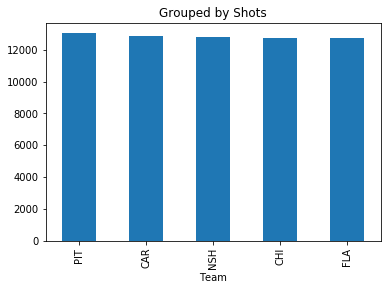

In [186]:
reset_player_data.groupby('Team').Shots.sum().sort_values(ascending=False)[:5].plot.bar()
plt.title('Grouped by Shots')
plt.show

Based on this basic test, with the data grouped by 'Teams', we sorted our values by **Shots** and from this, we are able to infer the Top 5 teams are;
**Pittsburgh Penguins**, **Carolina Hurricanes**, **Nashville Predators**, **Chicago Blackhawks** and **Florida Panthers** for shots

In [187]:
# Grouped by shot attempts to see the Top 5 Teams with players that outperform the rest
grouped_shot_attempts = player_data[['Shots','Shot Attempts','TOI']].groupby(player_data['Team']).aggregate(sum).sort_values(by ='Shot Attempts',ascending=False)
grouped_shot_attempts.head(10)

,Shots,Shot Attempts,TOI
Team,,,
CAR,12858,24573,119964.583333
S.J,12513,24284,117909.650000
TOR,12372,23797,115931.250000
NSH,12784,23702,119253.250000
DAL,12390,23687,116940.916667
PHI,12583,23681,120046.216667
CHI,12749,23526,117140.000000
L.A,12234,23475,117412.350000
BOS,12721,23297,115832.433333


The teams were also grouped by **Shot Attempts** and different teams were in the top 5; **Washington Capitals**, **Boston Bruins** ,**St Louis Blues**, **New York Islanders** and **Edmonton Oilers**

In [189]:
# Grouped by time on Ice because TOI is the variable that will determine if these shot variables are related to the time spent in the rink
grouped_toi = player_data[['Shots','Shot Attempts','TOI']].groupby(player_data['Team']).aggregate(sum).sort_values(by ='TOI',ascending=False)
grouped_toi.head(10)

,Shots,Shot Attempts,TOI
Team,,,
PHI,12583,23681,120046.216667
CAR,12858,24573,119964.583333
NSH,12784,23702,119253.250000
WSH,12085,22993,119004.066667
NYI,12340,22821,118973.716667
FLA,12729,22329,118835.233333
STL,12357,22472,118557.800000
WPG,12267,22706,118319.716667
DET,11739,21466,118046.916667


<function matplotlib.pyplot.show(*args, **kw)>

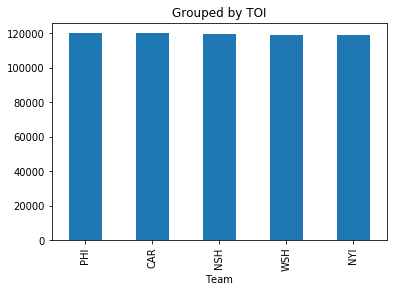

In [190]:
reset_player_data.groupby('Team').TOI.sum().sort_values(ascending=False)[:5].plot.bar()
plt.title('Grouped by TOI')
plt.show

The players are finally, are grouped by **TOI**. Based on this basic analysis, we can infer the teams that spend the most time on the ice are; 
**Philadelphia Flyers**, **Carolina Hurricanes**, **Nashville Predators**, **Washington Capitals** and **New York Islanders**

(3.0, 0.0)

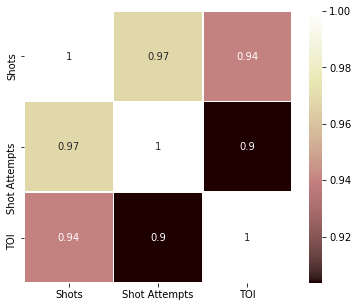

In [57]:
# A correlation matrix to see 
plt.figure(figsize=(6,5))
grouped_shots=player_data[['Shots','Shot Attempts','TOI']].groupby(player_data['Team']).aggregate(sum).sort_values(by ='Shots',ascending=False)
ax = sns.heatmap(grouped_shots.corr(),cmap='pink', annot=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### Conclusion
Based on this correlation matrix, we can see there is a strong correlation between shots/shot attempts and the time a player spends on ice. We see that these two variables are strongly related but that's still not enough information to decide.

### Consistency over the Years'

In [58]:
# I am resetting the data to use the column 'Year' as a numerical index
reset_player_data = player_data.reset_index()
reset_player_data.head()

,Year,Player,Team,Position,GP,TOI,Goals,Total Assists,First Assists,Second Assists,Total Points,Shots,SH%,Shot Attempts,Hits,Hits Taken
0,2015,Jamie Benn,DAL,F,82,1635.733333,35,52,32,20,87,253,13.83,466,120,101
1,2015,John Tavares,NYI,F,82,1695.200000,38,48,30,18,86,278,13.67,471,48,103
2,2015,Sidney Crosby,PIT,F,77,1538.533333,28,56,31,25,84,237,11.81,380,66,117
3,2015,Alex Ovechkin,WSH,F,81,1646.400000,53,28,21,7,81,395,13.42,825,259,108
4,2015,Jakub Voracek,PHI,F,82,1524.633333,22,59,31,28,81,221,9.95,424,55,139


In [59]:
top_teams = reset_player_data.groupby('Year')[['Shots', 'Shot Attempts', 'TOI']].aggregate(['min','max', 'mean'])
top_teams.head(5)

Shots                  Shot Attempts                          TOI  \
       min  max        mean           min  max        mean         min   
Year                                                                     
2015     8  395  104.575624            16  825  195.558003  158.216667   
2016     4  398  102.554269            14  779  191.272069  173.066667   
2017    11  321  106.992582            21  778  199.011869  164.566667   
2018     8  355  111.087571            14  775  204.789548  156.816667   
2019     7  365  106.340659            13  689  194.505495  162.200000   

                                
              max         mean  
Year                            
2015  2377.666667  1034.805311  
2016  2375.916667  1017.358562  
2017  2225.833333  1045.363699  
2018  2200.516667  1028.744656  
2019  2188.750000   998.498970

In [14]:
x = reset_player_data.TOI
y = reset_player_data.Shots

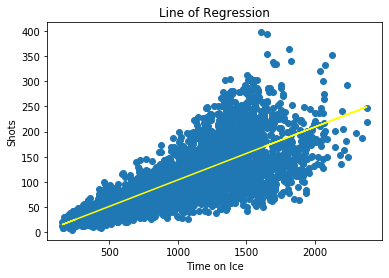

In [157]:
stats = linregress(x, y)

m = stats.slope
b = stats.intercept

plt.scatter(x, y)
plt.plot(x, m * x + b, color="yellow")  
plt.title('Line of Regression')
plt.xlabel('Time on Ice')
plt.ylabel('Shots')

plt.show()

Based on the scatter plot, it would appear, the longer the players are on the ice, the higher they are likely to take shots. It also appears we have some outliers and outliers could impact the correlation. To find out more, we will run the linear regression without outliers 

In [32]:
reset_player_data['Shots'] = np.ones((len(reset_player_data), ))

# Define X and Y variables for the regression.
Y = reset_player_data.TOI[:-1]
X = reset_player_data[['Shots','Shot Attempts']][:-1]
result_no_outlier = sm.OLS( Y, X).fit()

In [120]:
result_no_outlier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TOI   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     7001.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        07:03:14   Log-Likelihood:                -24407.
No. Observations:                3481   AIC:                         4.882e+04
Df Residuals:                    3479   BIC:                         4.883e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Shots           388.5320      8.862     43.844      0.000     371.157     405.907
Shot Attempts     3.2284      0.039     83.671      0.000       3.153       3.304
==============================================================================
Omnibus:                      186.518   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.002
Skew:                           0.527   Prob(JB):                     3.43e-52
Kurtosis:                       3.724   Cond. No.                         447.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
X_o = reset_player_data[['Shots','Shot Attempts']]
Y_o = reset_player_data.TOI

result_with_outlier = sm.OLS( Y_o, X_o ).fit()

In [43]:
result_with_outlier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TOI   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     7008.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        04:23:14   Log-Likelihood:                -24414.
No. Observations:                3482   AIC:                         4.883e+04
Df Residuals:                    3480   BIC:                         4.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Shots           388.2848      8.858     43.833      0.000     370.917     405.653
Shot Attempts     3.2293      0.039     83.714      0.000       3.154       3.305
==============================================================================
Omnibus:                      186.695   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.347
Skew:                           0.527   Prob(JB):                     2.89e-52
Kurtosis:                       3.726   Cond. No.                         447.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
team_data = fetch_team_data()
team_data.head(5)

Wins  Losses  Overtime Losses  Points
Year Team                                                      
2015 Anaheim Ducks          51      24                7     109
     Arizona Coyotes        24      50                8      56
     Boston Bruins          41      27               14      96
     Buffalo Sabres         23      51                8      54
     Carolina Hurricanes    30      41               11      71

In [156]:
team_data.describe()

,Wins,Losses,Overtime Losses,Points
count,152.000000,152.000000,152.000000,152.000000
mean,40.993421,31.546053,9.447368,91.434211
std,7.626632,7.088690,2.813848,14.446371
min,22.000000,16.000000,4.000000,48.000000
25%,35.000000,26.000000,7.000000,80.750000
50%,42.000000,30.000000,9.000000,95.000000
75%,47.000000,36.250000,11.000000,101.000000
max,62.000000,56.000000,18.000000,128.000000


In [158]:
reset_team_data = team_data.reset_index()
reset_team_data.head()

,Year,Team,Wins,Losses,Overtime Losses,Points
0,2015,Anaheim Ducks,51,24,7,109
1,2015,Arizona Coyotes,24,50,8,56
2,2015,Boston Bruins,41,27,14,96
3,2015,Buffalo Sabres,23,51,8,54
4,2015,Carolina Hurricanes,30,41,11,71


In [166]:
grouped_team = reset_team_data.groupby(reset_team_data['Wins']).aggregate('max').sort_values(by ='Wins',ascending=False)
grouped_team.head(5)

,Year,Team,Losses,Overtime Losses,Points
Wins,,,,,
62,2019,Tampa Bay Lightning,16,4,128
56,2016,Washington Capitals,18,8,120
55,2017,Washington Capitals,19,8,118
54,2018,Tampa Bay Lightning,23,5,113
53,2018,New York Rangers,22,11,117


After running the regression, it turns out R squared is not able to provide further information into the relationship between these variables.

With my Rsquared values remaining constant, it might just be further proof that time on Ice is related to shots/shot attempts. 

 I don't think we have enough information not with the OLS analysis alone because we know, in this instance, 
R-squared did not allow us to compare models. Perhaps considering most of the data was not outliers, if the OLS regression is to provide us with the most accurate prediction possible with convuluted data, then maybe having data specific and clean as ours did not require deeper analysis. 

## Conclusion

It would appear on average,more players in 'F' - Forward (Center, Left, Right Wing) positions have more shots and shot attempts, there it makes sense that the SH% (Shooting percentage) is higher for the F's than for D's. 

In our Grouped Data for Shots/Shot Attempts and Time on Ice, the two team that had appeared in more than one Data set was; **Carolina Hurricanes** and **Nashville Predators**. What odd is, they weren't part of the top 5 teams based on winning. So while the analysis has shown us time on ice and shot variables seem to be related. Reality has shown us, shot variables does not a winner make. 



